In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 39.4 MB/s 
     |████████████████████████████████| 189 kB 48.5 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 279 kB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2012)
path.ls()

(#6) [Path('/root/.fastai/data/pascal_2012/train'),Path('/root/.fastai/data/pascal_2012/train.json'),Path('/root/.fastai/data/pascal_2012/train.csv'),Path('/root/.fastai/data/pascal_2012/segmentation'),Path('/root/.fastai/data/pascal_2012/valid.json'),Path('/root/.fastai/data/pascal_2012/test')]

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,2008_000002.jpg,tvmonitor,True
1,2008_000003.jpg,train person,True
2,2008_000007.jpg,boat,True
3,2008_000008.jpg,horse person,False
4,2008_000009.jpg,cow,True


In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(df)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


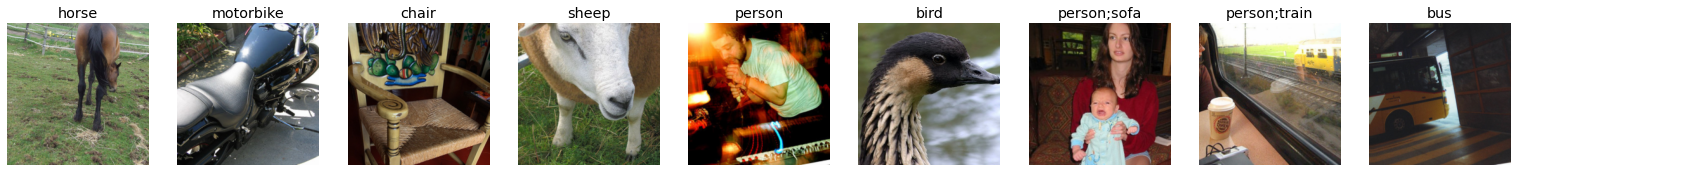

In [ ]:
dls.show_batch(nrows=1, ncols=10)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.862072,0.625375,0.226928,01:39
1,0.577379,0.235143,0.732337,01:39
2,0.230015,0.114627,0.945561,01:40
3,0.144769,0.103693,0.947965,01:39


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.116314,0.107341,0.952696,01:54
1,0.102470,0.095719,0.952756,01:53
2,0.080813,0.090564,0.956560,01:53


In [ ]:
preds,targs = learn.get_preds()

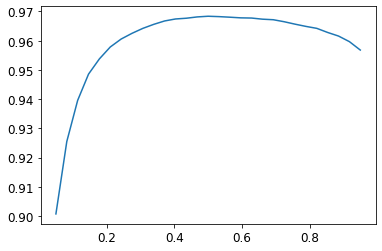

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.824725,0.575334,0.718066,03:46
1,0.534117,0.203542,0.956680,03:43
2,0.198415,0.082606,0.971853,03:44
3,0.115272,0.078277,0.972737,03:45


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.094893,0.088681,0.970522,04:31
1,0.083464,0.074305,0.974670,04:32
2,0.062371,0.071188,0.975520,04:31


SuggestedLRs(valley=9.999999747378752e-06)

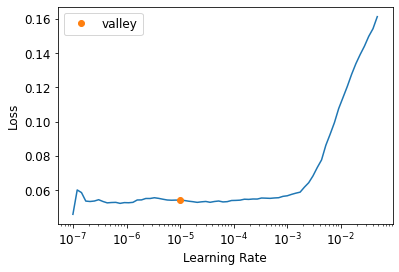

In [ ]:
learn.lr_find()

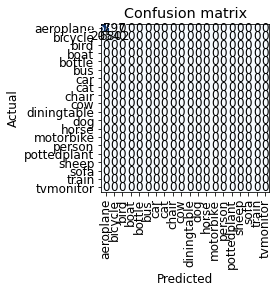

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

,target,predicted,probabilities,loss
0,boat;chair;motorbike;person;pottedplant,aeroplane;car,"TensorBase([[9.6067e-01, 2.5549e-03, 1.1579e-03, 1.1287e-02, 1.3112e-03, 5.9132e-03, 7.2074e-01, 2.5629e-03, 1.8870e-02, 4.8313e-03, 1.0573e-02, 1.0918e-03, 6.9746e-04, 2.7632e-03, 3.5057e-01, 1.1793e-02,\n 4.2740e-03, 4.1117e-03, 1.3041e-02, 8.6620e-04]])",1.2199357748031616


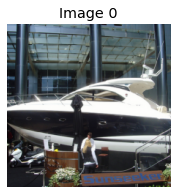

In [ ]:
interp.plot_top_losses(1, nrows=1)

['train']


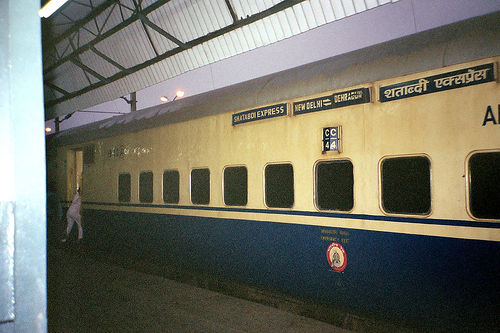

In [ ]:
img = '/root/.fastai/data/pascal_2012/train/2008_000003.jpg'
print(learn.predict(img)[0])
Image.open(img)

In [ ]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [ ]:
def on_data_change(change):
    lbl_pred.value = ''
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    output = "Found objects: "
    if len(pred) == 0:
      output += "none  "
    for p in pred:
      output += p + ", "
    output = output[:-2]
    lbl_pred.value = output


In [ ]:
btn_upload.observe(on_data_change, names=['data'])

In [ ]:
from fastai.vision.all import *
from fastai.vision.widgets import *

categories = "Possible labels: "
for x in learn.dls.vocab:
  categories += x + ", "
categories = categories[:-2]

display(VBox([widgets.Label(categories), btn_upload, out_pl, lbl_pred]))

In [ ]:
learn.export()
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]